The aim of this project is to analyze historical stock prices of a publicly traded company (in this case, TCS.NS) and build predictive models to forecast the next day’s closing price. Using past stock movements and trends, we attempt to capture patterns that may help anticipate short-term price fluctuations.

Dataset Overview:

The dataset is obtained directly from Yahoo Finance using the yfinance Python library.

It includes daily stock prices, specifically: Open, High, Low, Close, Adjusted Close, and Volume.

After preprocessing, we focus on the Close price, as it is the most widely used reference for stock valuation and prediction.


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime

In [2]:
TICKER = "TCS.NS"
START = "2023-01-01"
END = datetime.date.today().strftime("%Y-%m-%d")
LOOKBACK_DAYS = 5

In [4]:
#downloading stock data
df = yf.download(TICKER, start=START, end=END, progress=False)
df = df[['Close']].dropna()
df.reset_index(inplace=True)

/tmp/ipython-input-1216183780.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START, end=END, progress=False)


In [20]:
import yfinance as yf

TICKER = "TCS.NS"
df = yf.download(TICKER, progress=False)
print(df.columns)


/tmp/ipython-input-3938587873.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, progress=False)


MultiIndex([( 'Close', 'TCS.NS'),
            (  'High', 'TCS.NS'),
            (   'Low', 'TCS.NS'),
            (  'Open', 'TCS.NS'),
            ('Volume', 'TCS.NS')],
           names=['Price', 'Ticker'])


In [22]:
# Flatten column names if they are MultiIndex (common with yfinance)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
print(df.columns)

Index(['Close_TCS.NS', 'High_TCS.NS', 'Low_TCS.NS', 'Open_TCS.NS',
       'Volume_TCS.NS'],
      dtype='object')


In [23]:
df = df[['Close_TCS.NS']].copy()  # Use the exact column name from flattened columns
df.reset_index(inplace=True)


2. Creating additional features from the historical closing prices to help the models capture trends and patterns:

Lag features (lag_1 to lag_5): Represent the closing prices from the previous 1 to 5 days. These features allow models to learn momentum and short-term trends.

Moving averages (ma_5, ma_10): 5-day and 10-day simple moving averages smooth out daily price fluctuations and capture overall trend directions.

Rows containing NaN values (resulting from lag or moving average calculations) are removed to ensure a clean dataset for modeling.

In [24]:
# 2. Feature engineering: create lag features and moving averages
for lag in range(1, LOOKBACK_DAYS + 1):
    df[f'lag_{lag}'] = df['Close_TCS.NS'].shift(lag)
df['ma_5'] = df['Close_TCS.NS'].rolling(5).mean()
df['ma_10'] = df['Close_TCS.NS'].rolling(10).mean()
df.dropna(inplace=True)
df['target'] = df['Close_TCS.NS'].shift(-1)
df.dropna(inplace=True)


In [25]:

print(df.columns)


Index(['Date', 'Close_TCS.NS', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'ma_5', 'ma_10', 'target'],
      dtype='object')


In [12]:
df.columns = df.columns.map(lambda x: x[1:-1].replace("'", "").replace(" ", "").split(",")[0])


3. Defining Target Variable
The target variable, target, represents the next day’s closing price. This is created by shifting the Close column by -1. The last row, which does not have a next day value, is dropped to avoid errors during model training.

In [26]:
# 3. Define target variable

# Predict next day close
close_col = [c for c in df.columns if c.lower().startswith('close')][0]  # automatically find Close column
df['target'] = df[close_col].shift(-1)
df.dropna(inplace=True)  # drop last row where target is NaN

4. Defining Features and Target Arrays
The feature set X includes all lag features and moving averages, while y is the target variable. A safety check ensures that all required columns exist before training. This step prepares the data for supervised learning models.

In [27]:
# 4. Define features and target arrays

features = [c for c in df.columns if c.startswith('lag_') or c.startswith('ma_')]
target = 'target'

# Safety check
missing_cols = [col for col in features + [target] if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing columns in DataFrame: {missing_cols}")

X = df[features]
y = df[target]

print(f"Data ready. Total rows after feature engineering: {len(df)}")
print("Feature columns:", X.columns.tolist())

Data ready. Total rows after feature engineering: 13
Feature columns: ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'ma_5', 'ma_10']


5. Training-Test Split
The dataset is split into training and testing sets using an 80-20 split, respecting the time-series order (i.e., no shuffling). This ensures that models are trained on past data and tested on future data, simulating real-world prediction scenarios.

In [28]:
# 5. Train-test split (time-series aware)

split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


Training samples: 10, Testing samples: 3


6. Linear Regression Model
A Linear Regression model is trained on the training set. This model captures linear relationships between the lag and moving average features and the next day’s closing price. Predictions are generated for the test set, and model performance is evaluated using RMSE and R² metrics.

In [30]:
# 6. Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

rmse_lr = mean_squared_error(y_test, pred_lr) ** 0.5

r2_lr = r2_score(y_test, pred_lr)


7. Random Forest Model
A Random Forest Regressor, an ensemble of decision trees, is trained on the same features. This model can capture non-linear relationships and complex interactions among features. Test set predictions are evaluated using RMSE and R², providing a benchmark against Linear Regression.

In [31]:
# 7. Random Forest

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

rmse_rf = mean_squared_error(y_test, pred_rf) ** 0.5  # Manual RMSE
r2_rf = r2_score(y_test, pred_rf)


8. Printing Model Performance
The performance of both models is displayed, including RMSE (lower values indicate more accurate predictions) and R² (higher values indicate better explanation of variance). This comparison helps identify which model better captures the stock price behavior.

In [32]:
# 8. Print model performance

print("\nModel performance on test set:")
print(f"Linear Regression -> RMSE: {rmse_lr:.3f}, R2: {r2_lr:.3f}")
print(f"Random Forest     -> RMSE: {rmse_rf:.3f}, R2: {r2_rf:.3f}")


Model performance on test set:
Linear Regression -> RMSE: 64.181, R2: -20.672
Random Forest     -> RMSE: 109.184, R2: -61.720


Interpretation of Model Performance

The models were evaluated on the test set using RMSE and R² metrics:

Linear Regression achieved an RMSE of 64.181 and an R² of -20.672.

Random Forest achieved an RMSE of 109.184 and an R² of -61.720.

Interpretation:

RMSE indicates the average deviation of the predicted closing prices from the actual prices. Linear Regression’s predictions are, on average, about 64 units away from the actual price, while Random Forest’s predictions deviate by about 109 units.

R² represents how well the model explains the variance in the data. Both models have negative R² values, which indicates that they perform worse than a simple baseline model that predicts the mean closing price for all days.

Conclusion:

Both models are unable to accurately predict the next day closing prices using only past 5-day lag values and simple moving averages.

Linear Regression performs relatively better than Random Forest but is still not reliable for forecasting in its current setup.

These results highlight the high volatility and unpredictability of stock prices, suggesting that more advanced features or time-series models might be needed for meaningful predictions.

9. Ploting Actual vs Predicted
A line plot is generated for the last N days of the test set, showing:

Actual closing prices

Predictions from Linear Regression

Predictions from Random Forest
This visualization allows intuitive evaluation of how closely each model tracks the actual stock movements.

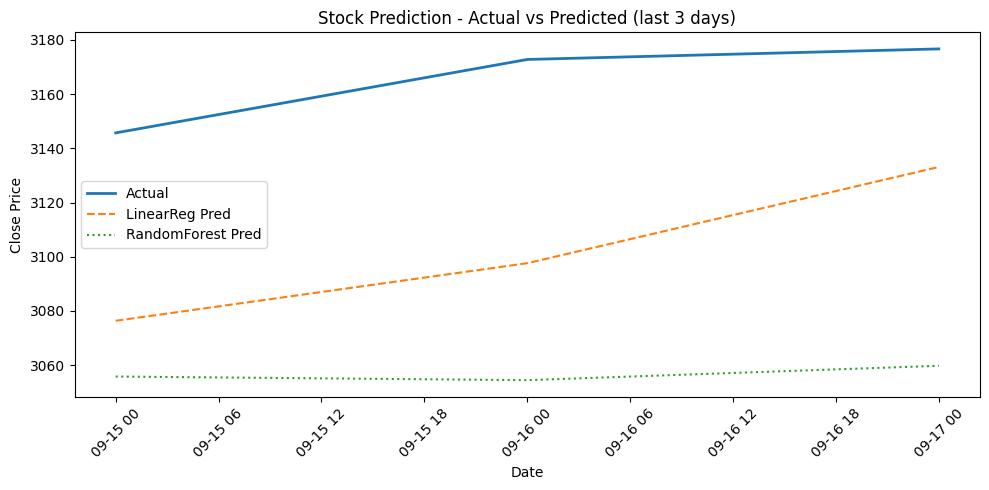

In [33]:
# 9. Plot actual vs predicted


plot_n = min(60, len(y_test))
idx_plot = y_test.index[-plot_n:]

plt.figure(figsize=(10, 5))
plt.plot(df.loc[idx_plot, 'Date'], y_test.iloc[-plot_n:].values, label='Actual', linewidth=2)
plt.plot(df.loc[idx_plot, 'Date'], pred_lr[-plot_n:], label='LinearReg Pred', linestyle='--')
plt.plot(df.loc[idx_plot, 'Date'], pred_rf[-plot_n:], label='RandomForest Pred', linestyle=':')
plt.xticks(rotation=45)
plt.title(f"Stock Prediction - Actual vs Predicted (last {plot_n} days)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.savefig("actual_vs_predicted.png", dpi=150)
plt.show()


In [34]:
# 10. Save results CSV

results = pd.DataFrame({
    'Date': df.loc[y_test.index, 'Date'],
    'Actual': y_test.values,
    'LR_Pred': pred_lr,
    'RF_Pred': pred_rf
})
results.to_csv("predictions.csv", index=False)

print("\nSaved plot: actual_vs_predicted.png")
print("Saved predictions: predictions.csv")


Saved plot: actual_vs_predicted.png
Saved predictions: predictions.csv
